In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [20]:
column_names = ['Sexo', 'Percentil', 'Edad', 'IMC']
raw_dataset = pd.read_csv("IMC_Varones_y_mujeres.csv", names=column_names, sep=',',skiprows=1)

In [21]:
dataset = raw_dataset.copy()

In [22]:
# Cambio M y V por 1 y 0 paso todas las columnas a float32
dataset = pd.get_dummies(dataset, columns = ['Sexo'], prefix='', prefix_sep='',dtype=int).astype("float32")

In [23]:
# Agarro un 80% para entrenar
train_dataset = dataset.sample(frac=0.8, random_state=0)

# Saco los entrenados
test_dataset = dataset.drop(train_dataset.index)


In [24]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# Extraigo de los datos el resultado que espero obtener
train_labels = train_features.pop('Percentil')
test_labels = test_features.pop('Percentil')



In [25]:
# Normalizo tomando la última columna como referencia (pero normaliza todas)
normalizer = tf.keras.layers.Normalization(axis=-1)

In [26]:
normalizer.adapt(np.array(train_features))

In [27]:
model = keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [28]:
%%time
history = model.fit(
    train_features,
    train_labels,
    epochs=225,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 9.4 s, sys: 1.38 s, total: 10.8 s
Wall time: 7.15 s


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 60])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Percentil]')
  plt.legend()
  plt.grid(True)

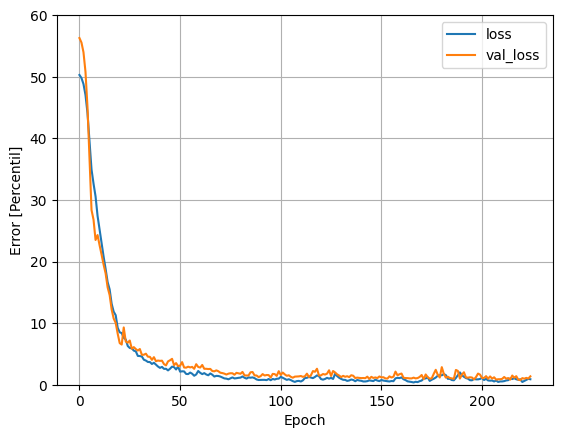

In [30]:
plot_loss(history)

In [31]:
#test_results = {}

test_results = model.evaluate(
    test_features, test_labels, verbose=1)

test_results

2/2 [==============================] - 0s 3ms/step - loss: 1.2113


1.2113115787506104

In [32]:
from IPython.display import display, HTML

predictions = model.predict(test_features)

df2 = pd.concat([test_features,test_labels], axis=1)
#df3 = pd.concat([df2,pd.DataFrame(predictions)], axis =1)

# display the DataFrame
# format the HTML table to display the DataFrames side by side
html = '''
<table>
  <tr>
    <td>{}</td>
    <td>{}</td>
  </tr>
</table>
'''

# display the formatted HTML table with the three DataFrames
display(HTML(html.format(df2.to_html(), pd.DataFrame(predictions).to_html())))

2/2 [==============================] - 0s 3ms/step


In [33]:
un_valor1 = np.array([[16.000942, 20.700886, 1.0, 0.0]], dtype=np.float32)

prediction = model.predict(un_valor1)

prediction

1/1 [==============================] - 0s 15ms/step


array([[49.802]], dtype=float32)

In [34]:
un_valor2 = np.array([[7.011268, 12.637012, 0.0, 1.0]], dtype=np.float32)

prediction = model.predict(un_valor2)

prediction

1/1 [==============================] - 0s 16ms/step


array([[3.032]], dtype=float32)

In [35]:
model.save('IMC-Copy2')
model.summary()

INFO:tensorflow:Assets written to: IMC-Copy2/assets


INFO:tensorflow:Assets written to: IMC-Copy2/assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                      

In [36]:
# Save the model
SAVED_MODEL_PATH = '/tmp/clau'

tf.saved_model.save(
    model, SAVED_MODEL_PATH,
)


INFO:tensorflow:Assets written to: /tmp/clau/assets


INFO:tensorflow:Assets written to: /tmp/clau/assets


In [37]:
converter = tf.lite.TFLiteConverter.from_saved_model('/tmp/clau') # path to the SavedModel directory

tflite_model = converter.convert()

# https://www.tensorflow.org/lite/models/convert/convert_models
# Convert the model.
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

# Print the signatures from the converted model
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

{'serving_default': {'inputs': ['normalization_1_input'], 'outputs': ['dense_11']}}


2023-06-24 23:37:14.135793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-24 23:37:14.135936: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-24 23:37:14.137233: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/clau
2023-06-24 23:37:14.143393: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-24 23:37:14.143466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/clau
2023-06-24 23:37:14.153205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-06-24 23:37:14.155370: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-06-24 23:37:14.222977: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/clau
2023-06-24 23:37:14.234794: 